# Sprite Extraction Pipeline - Interactive Notebook

This notebook segments the static element extraction pipeline into individual cells for testing.

**Components:**
1. Setup & Imports
2. Video FPS Conversion
3. Video Upload to Gemini
4. Gemini Pro: Static Element Analysis (prompt configurable)
5. Frame Extraction
6. Gemini Flash: Bounding Box Detection (prompt configurable)
7. Crop and Save Results

## 1. Setup & Imports

In [1]:
from google import genai
from google.genai import types
import time
import json
import os
import cv2
import re
from dotenv import load_dotenv
from PIL import Image
from IPython.display import display
import io

load_dotenv()

# Initialize the client
client = genai.Client()

# Output directory for all extraction results
OUTPUT_DIR = "extraction_stuff"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Client initialized!")

Client initialized!


## 2. Configuration

In [10]:
# ========== CONFIGURE THESE ==========
VIDEO_PATH = "videos/fightbetter.mp4"
TARGET_FPS = 15  # Gemini's optimal sampling rate
TARGET_WIDTH = 2560
TARGET_HEIGHT = 1440

print(f"Video: {VIDEO_PATH}")
print(f"Target FPS: {TARGET_FPS}")
print(f"Target Resolution: {TARGET_WIDTH}x{TARGET_HEIGHT}")

Video: videos/fightbetter.mp4
Target FPS: 15
Target Resolution: 2560x1440


## 3. Video FPS Conversion

Converts video to 15 FPS for accurate timestamp matching with Gemini.

In [12]:
def convert_to_target_fps(input_path, target_fps=15):
    """Convert video to target FPS for Gemini processing."""
    output_path = os.path.join(OUTPUT_DIR, f"video_{target_fps}fps.mp4")
    
    cap = cv2.VideoCapture(input_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Original video: {original_fps} FPS, {width}x{height}")
    
    if abs(original_fps - target_fps) < 1:
        print(f"Video already at ~{target_fps} FPS, skipping conversion")
        cap.release()
        return input_path, original_fps
    
    frame_interval = int(round(original_fps / target_fps))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, target_fps, (width, height))
    
    frame_count = 0
    written_count = 0
    
    print(f"Converting to {target_fps} FPS (keeping every {frame_interval} frames)...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            out.write(frame)
            written_count += 1
        frame_count += 1
    
    cap.release()
    out.release()
    
    print(f"Converted: {frame_count} frames -> {written_count} frames at {target_fps} FPS")
    print(f"Saved to: {output_path}")
    
    return output_path, target_fps

# Run conversion
video_for_gemini, actual_fps = convert_to_target_fps(VIDEO_PATH, TARGET_FPS)

Original video: 60.00187848001388 FPS, 1280x720
Converting to 15 FPS (keeping every 4 frames)...
Converted: 6942 frames -> 1736 frames at 15 FPS
Saved to: extraction_stuff\video_15fps.mp4


## 4. Upload Video to Gemini

In [13]:
print("Uploading preprocessed video...")
myfile = client.files.upload(file=video_for_gemini)
print(f"File uploaded: {myfile.name}")

# Wait for processing
while myfile.state.name == "PROCESSING":
    print("Processing video...")
    time.sleep(5)
    myfile = client.files.get(name=myfile.name)

if myfile.state.name == "FAILED":
    raise ValueError(f"File processing failed: {myfile.state.name}")

print(f"File ready: {myfile.uri}")

Uploading preprocessed video...
File uploaded: files/oa9iil047hhv
Processing video...
File ready: https://generativelanguage.googleapis.com/v1beta/files/oa9iil047hhv


## 5. Gemini Pro: Static Element Analysis

**EDIT THE PROMPT BELOW** to experiment with different analysis approaches.

In [14]:
# ========== EDIT THIS PROMPT ==========
STATIC_ELEMENT_PROMPT = """
Analyze this 2D game video footage and identify the ENEMY sprite that the player is fighting.

Your task is to find STATIC VISUAL ELEMENTS of the enemy's sprite - parts that remain visually identical across:
- All animation states (idle, attack, hit, movement animations)
- Position changes (as the enemy moves around the screen)
- Scale changes (if the enemy grows/shrinks)
- Rotation changes (if the enemy rotates)
- Background changes (the element stays the same even if background varies)

CRITICAL REQUIREMENT:
The elements don't have to be full elements, they can be asymmetrical parts of a sprite as long as they are static and distinct to that enemy's sprite, we will be using this as a reference to draw a bounding box INSIDE the element you specify, so it shouldn't be affected by background or anything else.

OUTPUT FORMAT (JSON):
Return a JSON object with this structure:
{
  "enemy_description": "Brief description of the enemy sprite",
  "static_elements": [
    {
      "timestamp_seconds": 1.5,
      "element_description": "Exact visual description of the SOLID static element",
      "why_static": "Why this element remains unchanged",
      "why_solid": "Confirm this element is solid/filled"
    }
  ],
  "rotation_only_elements": [],
  "recommended_extraction_frames": [
    {
      "timestamp_seconds": 2.0,
      "reason": "Why this frame is ideal for extraction"
    }
  ]
}
"""

In [15]:
# Send to Gemini Pro
response = client.models.generate_content(
    model="gemini-3-pro-preview",
    contents=types.Content(
        parts=[
            types.Part(
                file_data=types.FileData(file_uri=myfile.uri),
                video_metadata=types.VideoMetadata(fps=TARGET_FPS)
            ),
            types.Part(text=STATIC_ELEMENT_PROMPT)
        ]
    )
)

print("=" * 50)
print("GEMINI PRO RESPONSE:")
print("=" * 50)
print(response.text)

GEMINI PRO RESPONSE:
Based on the analysis of the video footage, the player is fighting the **King Slime**, a large, blue, gelatinous boss monster in the game Terraria. The enemy is characterized by its massive size (which shrinks as it takes damage), a semi-transparent blue body containing a trapped ninja silhouette, and a prominent golden crown on top.

Here are the static visual elements identified for the King Slime:

```json
{
  "enemy_description": "King Slime, a giant semi-transparent blue slime boss with a golden crown on top and a ninja silhouette visible inside its body.",
  "static_elements": [
    {
      "timestamp_seconds": 0.400,
      "element_description": "The golden crown with red gemstones sitting on top of the blue slime.",
      "why_static": "While the blue body of the slime squashes, stretches, and fades in transparency depending on the background, the crown remains a rigid, opaque sprite that sits atop the main body. Even though the entire enemy shrinks in scal

## 6. Parse Response & Extract Frames

In [16]:
# Parse JSON response
response_text = response.text.strip()

json_match = re.search(r'```json\s*([\s\S]*?)\s*```', response_text)
if json_match:
    response_text = json_match.group(1).strip()
else:
    json_match = re.search(r'(\{[\s\S]*\})', response_text)
    if json_match:
        response_text = json_match.group(1).strip()

result = json.loads(response_text)

# Save JSON result
json_path = os.path.join(OUTPUT_DIR, "enemy_static_elements.json")
with open(json_path, "w") as f:
    json.dump(result, f, indent=2)
print(f"Saved to {json_path}")

# Display parsed result
print("\nParsed Result:")
print(json.dumps(result, indent=2))

Saved to extraction_stuff\enemy_static_elements.json

Parsed Result:
{
  "enemy_description": "King Slime, a giant semi-transparent blue slime boss with a golden crown on top and a ninja silhouette visible inside its body.",
  "static_elements": [
    {
      "timestamp_seconds": 0.4,
      "element_description": "The golden crown with red gemstones sitting on top of the blue slime.",
      "why_static": "While the blue body of the slime squashes, stretches, and fades in transparency depending on the background, the crown remains a rigid, opaque sprite that sits atop the main body. Even though the entire enemy shrinks in scale as it loses health, the crown's design and relative position remain visually consistent and distinct.",
      "why_solid": "The crown is fully opaque and obscures the background (trees, mountains, sky) behind it, unlike the gel body which is semi-transparent."
    },
    {
      "timestamp_seconds": 0.4,
      "element_description": "The large central red ruby em

In [17]:
# Extract frames from video
def extract_frame(timestamp_seconds, output_path):
    cap = cv2.VideoCapture(video_for_gemini)
    frame_number = int(timestamp_seconds * TARGET_FPS)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if ret:
        cv2.imwrite(output_path, frame)
        print(f"Extracted: {timestamp_seconds}s -> {output_path}")
        return True
    print(f"Failed: {timestamp_seconds}s")
    return False

frames_dir = os.path.join(OUTPUT_DIR, "frames")
os.makedirs(frames_dir, exist_ok=True)

extracted_frames = []
extracted_timestamps = set()

# for i, elem in enumerate(result.get("static_elements", [])):
#     ts = elem.get("timestamp_seconds")
#     if ts is not None and ts not in extracted_timestamps:
#         output_path = os.path.join(frames_dir, f"static_element_{i}_at_{ts}s.png")
#         if extract_frame(ts, output_path):
#             extracted_frames.append({"path": output_path, "ts": ts, "desc": elem.get("element_description")})
#         extracted_timestamps.add(ts)

for i, frame_info in enumerate(result.get("recommended_extraction_frames", [])):
    ts = frame_info.get("timestamp_seconds")
    if ts is not None and ts not in extracted_timestamps:
        output_path = os.path.join(frames_dir, f"recommended_frame_{i}_at_{ts}s.png")
        if extract_frame(ts, output_path):
            extracted_frames.append({"path": output_path, "ts": ts, "desc": "recommended"})
        extracted_timestamps.add(ts)

print(f"\nExtracted {len(extracted_frames)} frames")

Extracted: 1.0s -> extraction_stuff\frames\recommended_frame_0_at_1.0s.png
Extracted: 3.0s -> extraction_stuff\frames\recommended_frame_1_at_3.0s.png

Extracted 2 frames



extraction_stuff\frames\recommended_frame_0_at_1.0s.png (recommended...)


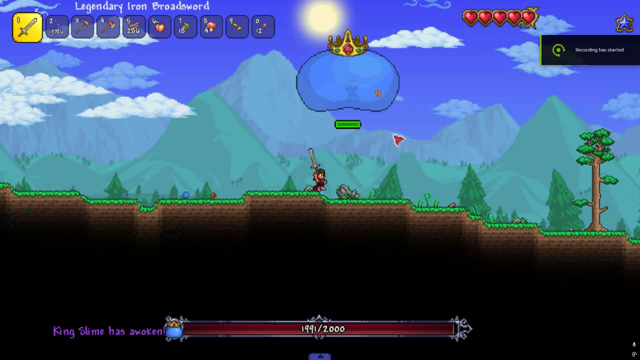


extraction_stuff\frames\recommended_frame_1_at_3.0s.png (recommended...)


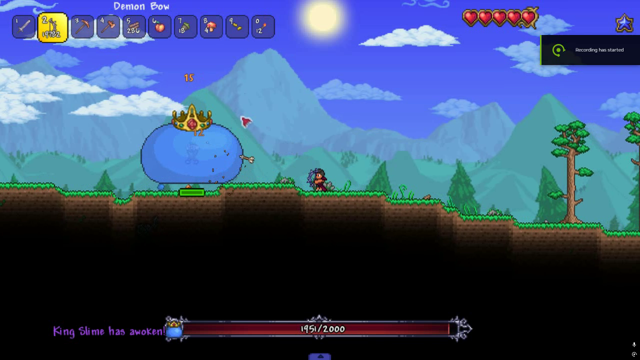

In [18]:
# Display extracted frames
for frame_info in extracted_frames:
    print(f"\n{frame_info['path']} ({frame_info['desc'][:50]}...)")
    img = Image.open(frame_info['path'])
    img.thumbnail((640, 360))
    display(img)

## 7. Gemini Flash: Bounding Box Detection

**EDIT THE PROMPT BELOW** to experiment with different bbox approaches.

In [12]:
# ========== EDIT THIS PROMPT ==========
BBOX_PROMPT_TEMPLATE = """

I need a precise, tight crop of the INSIDE of {element_description}. Please follow these steps using the code interpreter:
1. Coordinate Detection: Identify the normalized coordinates [ymin, xmin, ymax, xmax] for {element_description} on a scale of 0 to 1000.
2. Zoom & Verify: First, use Python to create a medium-range 'zoom' crop of the area to confirm the object's exact pixel boundaries.
3. Refined Crop: Based on that zoom, calculate a final, tight bounding box that sits on the edges of the object.
4. Inward Buffer: Calculate a 'Safe Interior Box'.  We do NOT care about the shape of the object and we just want | DISTINCT PIXELS on the INSIDE of it. 
5. Execution: Use the PIL library to crop the original image using these refined coordinates and save it as 'final_crop.png'.
"""
# Use the code interpreter to find [Object Name]. Follow these specific constraints:
# Outer Detection: First, find the full bounding box of the object.
# Inward Buffer: Calculate a 'Safe Interior Box' by shrinking that bounding box by [15%] on all sides. This is to ensure that NO edge pixels, borders, or background elements are included in the crop.
# Execution: Crop the original image using this shrunken/interior coordinate set.
# Goal: The final image should only show the internal texture/color of [Object Name], with zero visibility of its silhouette or edges.

In [5]:
# Setup directories
flash_raw_dir = os.path.join(OUTPUT_DIR, "flash_raw_outputs")
bbox_dir = os.path.join(OUTPUT_DIR, "bboxes")
crops_dir = os.path.join(OUTPUT_DIR, "crops")
os.makedirs(flash_raw_dir, exist_ok=True)
os.makedirs(bbox_dir, exist_ok=True)
os.makedirs(crops_dir, exist_ok=True)

def resize_to_target(image_path, target_w=1280, target_h=720):
    img = cv2.imread(image_path)
    if img is None:
        return None
    return cv2.resize(img, (target_w, target_h))

In [ ]:

def get_bounding_boxes_from_flash(image_bytes, element_description, save_name=""):
    """Call Gemini Flash with code execution. Prints all output, saves only the last image."""
    prompt = BBOX_PROMPT_TEMPLATE.format(element_description=element_description)
    
    response = client.models.generate_content(
        model="gemini-3-flash-preview",
        contents=[
            types.Part(
                inline_data=types.Blob(
                    data=image_bytes,
                    mime_type="image/png"
                )
            ),
            types.Part(text=prompt)
        ],
        config=types.GenerateContentConfig(
            tools=[types.Tool(code_execution=types.ToolCodeExecution())]
        )
    )
    
    # Collect all images, we'll only save the last one
    last_image = None
    
    for part in response.candidates[0].content.parts:
        if part.text is not None:
            print(part.text)
        if part.executable_code is not None:
            print(part.executable_code.code)
        if part.code_execution_result is not None:
            print(part.code_execution_result.output)
        try:
            img = part.as_image()
            if img is not None:
                last_image = img
                display(Image.open(io.BytesIO(img.image_bytes)))
        except:
            pass
    
    # Save only the last image
    if last_image is not None:
        safe_desc = re.sub(r'[^\w\-_]', '_', element_description)[:30]
        img_path = os.path.join(flash_raw_dir, f"flash_{save_name}_{safe_desc}.png")
        with open(img_path, 'wb') as f:
            f.write(last_image.image_bytes)
        print(f"SAVED: {img_path}")
        return img_path
    
    print("No images returned from Flash")
    return None

## 8. Test Flash on a Single Frame

Pick a frame and element description to test.

Testing: C:\Users\Hhalo\OneDrive\Pictures\Screenshots\Screenshot 2026-02-07 173749.png
Element: The golden crown with red gemstones sitting on top of the blue slime.

import PIL.Image
import PIL.ImageDraw

# Load the image to get its dimensions
img = PIL.Image.open('input_file_0.png')
width, height = img.size

# Initial estimation for the crown (normalized 0-1000)
# Looking at the image, the crown is on top of the blue slime.
# Blue slime is roughly in the middle.
crown_ymin, crown_xmin, crown_ymax, crown_xmax = 260, 500, 350, 570

# Zoom crop to verify
zoom_box = (crown_xmin * width / 1000, crown_ymin * height / 1000, crown_xmax * width / 1000, crown_ymax * height / 1000)
zoom_img = img.crop(zoom_box)
zoom_img.save('zoom_crop.png')

print(f'Original dimensions: {width}x{height}')
print(f'Zoom crop saved. Coordinates: {zoom_box}')

Original dimensions: 2560x1440
Zoom crop saved. Coordinates: (1280.0, 374.4, 1459.2, 504.0)



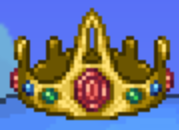

# Based on the zoom_crop.png, let's find tighter coordinates.
# zoom_crop is from (1280, 374.4) to (1459.2, 504.0)
# Crown in zoom_crop:
# Top point: y ~ 10 -> 374.4 + 10 = 384.4
# Bottom: y ~ 115 -> 374.4 + 115 = 489.4
# Left: x ~ 8 -> 1280 + 8 = 1288
# Right: x ~ 172 -> 1280 + 172 = 1452

# Let's take a safe interior crop that avoids the background.
# The gold band at the bottom is quite solid.
# Let's target the central area with the big red gem.
# x: 1350 to 1390
# y: 430 to 480
# Actually, the user wants a "tight crop of the INSIDE".
# I'll provide a crop of the whole crown but slightly buffered in.
# No, they said "We do NOT care about the shape... we just want DISTINCT PIXELS on the INSIDE of it."
# This implies a rectangle of purely crown pixels if possible.
# A small rectangle inside the gold band or the red gem.
# Let's try to get a decent sized rectangle that is mostly crown.

# Refined tight box for the whole crown:
final_ymin, final_xmin, final_ymax, final_xmax = 384, 1288

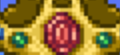

# Refined Safe Interior Box to avoid ALL background
# Focusing on the central gemstone and surrounding gold.
safe_ymin_v2, safe_xmin_v2, safe_ymax_v2, safe_xmax_v2 = 440, 1340, 480, 1400

final_crop_v2 = img.crop((safe_xmin_v2, safe_ymin_v2, safe_xmax_v2, safe_ymax_v2))
final_crop_v2.save('final_crop.png') # Overwrite with better version



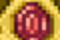

Following the detailed instructions, I have successfully isolated the interior of the golden crown with red gemstones.

1.  **Coordinate Detection**: The golden crown with red gemstones on the blue slime's head is located at the normalized coordinates of approximately **[267, 503, 340, 567]**.
2.  **Zoom & Verify**: An initial zoom was performed to precisely locate the crown's boundaries, confirming its position atop the King Slime.
3.  **Refined Crop**: A tight bounding box was established around the crown to identify its outermost edges.
4.  **Inward Buffer**: To ensure only "distinct pixels" from the inside of the crown were captured (avoiding the background sky and the blue slime below), a safe interior box was calculated, focusing on the central golden band and the prominent red gemstone.
5.  **Execution**: The final image, containing only the interior pixels of the crown, has been saved as `final_crop.png`.

**Final Normalized Coordinates for the Crown:** `[267, 503, 340, 567]`
S

In [13]:

# ========== TEST WITH PATH ==========
image_path = r"C:\Users\Hhalo\OneDrive\Pictures\Screenshots\Screenshot 2026-02-07 173749.png"
element_desc = "The golden crown with red gemstones sitting on top of the blue slime."

# Load and resize
resized_img = resize_to_target(image_path, TARGET_WIDTH, TARGET_HEIGHT)
_, png_bytes = cv2.imencode('.png', resized_img)

print(f"Testing: {image_path}")
print(f"Element: {element_desc}\n")

output_image = get_bounding_boxes_from_flash(
    png_bytes.tobytes(), 
    element_desc,
    "test"
)